# First check stack

Now that we have a complete geometry, lets make a first stack (very raw) to check if everything is coherent.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rsf.api as sf

%matplotlib inline

# Set a custom DATAPATH to Madagascar
%env DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/

env: DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/


In [2]:
sns.set_style('ticks')

## Input files

In [3]:
raw_data = 'seismic.segy'
common_shot = 'line_12_csg_raw.rsf'
mask = 'line_cdp_mask.rsf'
raw_cdp = 'line_raw_cdp.rsf'
offsets = 'line_cdp_offset.rsf'
stack = 'line_cvs_1500.rsf'
header_int = 'line_12_header_int.rsf'
header_complete = 'line_12_header_complete.rsf'

In [4]:
n2 = 120120 # Total number of traces

## Processing steps

 - Sort data in CMP Gathers
 - Extract offset sorted in CMP Gathers
 - Apply $t^2$ gain and stack with constant velocity of 1.5 km/s
 
These steps should result in a simple stacked session showing the sea bottom. Remember, in Madagascar we are using km and seconds as units.

In [5]:
!sfput n2={n2} n3=1 < {common_shot} | \
    sfintbin head={header_int} yk=cdp xk=cdpt mask={mask} > {raw_cdp}

sfintbin: 2142 of 2142;72 of 2142;


In [6]:
!sfintbin < {header_complete} head={header_int} yk=cdp xk=cdpt | \
    sfheadermath output='offset'/1000. > {offsets}

sfintbin: 2142 of 2142;88 of 2142;826 of 2142;1431 of 2142;1889 of 2142;


In [7]:
stack = 'line_12_stack_1500.rsf'

In [8]:
!sfpow pow1=2 < {raw_cdp} | \
    sfstacks half=n offset={offsets} nv=1 v0=1.5 dv=1 mask={mask} | \
    sftransp plane=23 | \
    sfput label2=cdp > {stack}

sfstacks: CMP 2142 of 2142; 8 of 2142;CMP 114 of 2142;CMP 273 of 2142;CMP 959 of 2142;


# Inspecting the stack inside the notebook

You can also make a quick check using
>    !sfgrey < {stack} | sfpen

In [9]:
stack = sf.Input(stack)

In [10]:
n1 = stack.int('n1')
n2 = stack.int('n2')
d1 = stack.float('d1')
o1 = stack.float('o1')

In [11]:
data = np.zeros((n2, n1), dtype=np.float32)
stack.read(data)

In [12]:
from matplotlib_scalebar.scalebar import ScaleBar

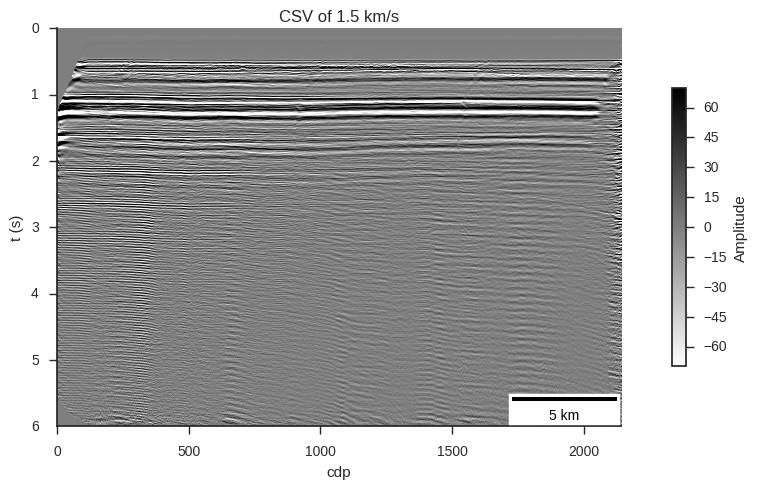

In [13]:
perc = np.percentile(data.ravel(), 99)
t = np.arange(n1) * d1 + o1
extent = [0, n2, t[-1], o1]
plt.figure(figsize=(8, 5))
img = plt.imshow(data.clip(-perc, perc).T, aspect='auto',
                 extent=extent, cmap='gray_r')


scalebar = ScaleBar(12.5, location='lower right') # 1 pixel = 12.5 meter
plt.gca().add_artist(scalebar)

plt.ylabel('t (s)')
plt.xlabel('cdp')

plt.title('CSV of 1.5 km/s')

sns.despine()
plt.colorbar(img, shrink=0.7, label='Amplitude', pad=0.07)

plt.tight_layout()

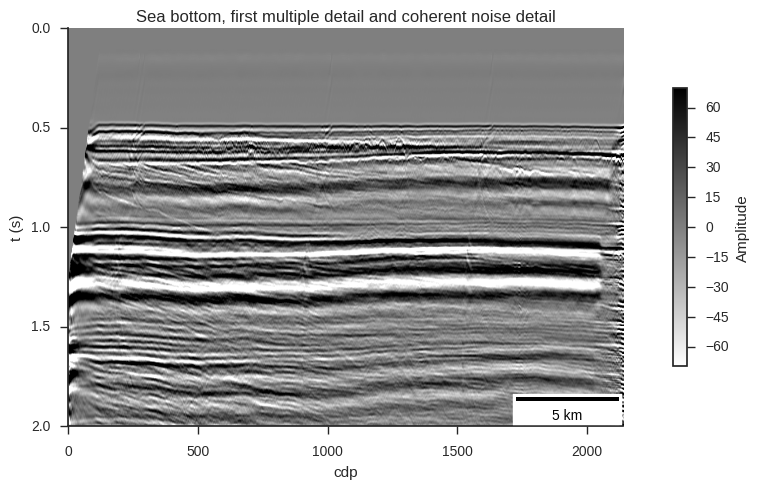

In [14]:
perc = np.percentile(data.ravel(), 99)
t = np.arange(n1) * d1 + o1
extent = [0, n2, t[-1], o1]
plt.figure(figsize=(8, 5))
img = plt.imshow(data.clip(-perc, perc).T, aspect='auto',
                 extent=extent, cmap='gray_r')

scalebar = ScaleBar(12.5, location='lower right') # 1 pixel = 12.5 meter
plt.gca().add_artist(scalebar)

plt.ylabel('t (s)')
plt.xlabel('cdp')

plt.ylim(2,0)

plt.title('Sea bottom, first multiple detail and coherent noise detail')

sns.despine()
plt.colorbar(img, shrink=0.7, label='Amplitude', pad=0.07)

plt.tight_layout()

The sea bottom is very clear in the image above, but we still have too much coherent noise. Also, all other velocities are wrong, so deeper events are being destroyed by the stacking.

## Checking for shot delays

In [15]:
!echo {common_shot}

line_12_csg_raw.rsf


In [16]:
offset_mask = 'line_offset_mask.rsf'

!sfheadermath output='offset'  < {header_complete} | sfmask min=-262 > {offset_mask}

first_traces = 'first_channel.rsf'

!sfheaderwindow mask={offset_mask} < {common_shot} >  {first_traces}

In [17]:
stack = sf.Input(first_traces)

n1 = stack.int('n1')
n2 = stack.int('n2')
d1 = stack.float('d1')
o1 = stack.float('o1')

data = np.zeros((n2, n1), dtype=np.float32)
stack.read(data)

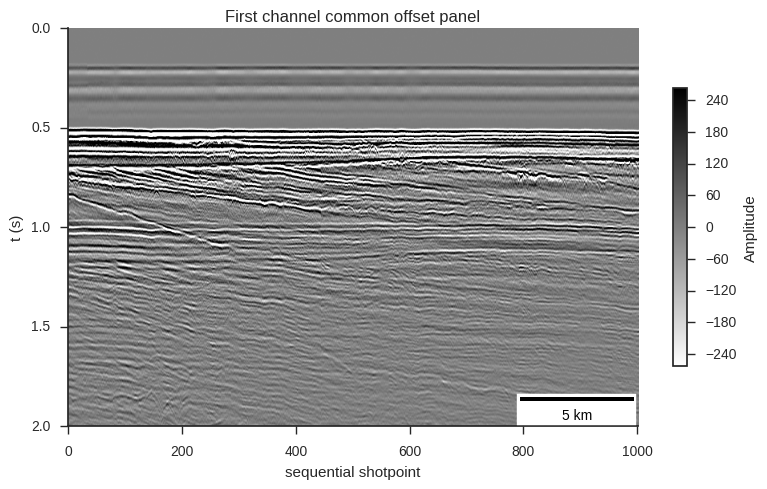

In [18]:
perc = np.percentile(data.ravel(), 99)
t = np.arange(n1) * d1 + o1
extent = [0, n2, t[-1], o1]
plt.figure(figsize=(8, 5))
img = plt.imshow(data.clip(-perc, perc).T, aspect='auto',
                 extent=extent, cmap='gray_r')


scalebar = ScaleBar(25, location='lower right') # 1 pixel = 25 meter
plt.gca().add_artist(scalebar)

plt.ylabel('t (s)')
plt.xlabel('sequential shotpoint')

plt.ylim(2,0)

plt.title('First channel common offset panel')

sns.despine()
plt.colorbar(img, shrink=0.7, label='Amplitude')

plt.tight_layout()

## First rough velan

Now lets try to make a first brute stack with a very rough velocity function. We also could try to use the wells here, but I think it would be more useful to use them a bit later.

In [19]:
# CDP window
start = 1502 - 5
lenght = 10

cdp_sample = 'raw_cdp_sample.rsf'
offset_sample = 'offset_cdp_sample.rsf'
mask_sample = 'mask_cdp_sample.rsf'

# !sfagc < {raw_cdp} | sfvscan offset={offsets} mask={mask} half=n \
#     semblance=y v0={v0} nv={nv} dv={dv} nb=10 > {semblance}

In [20]:
!sfwindow < {raw_cdp} f3={start} n3={lenght} > {cdp_sample}

In [21]:
!sfwindow < {offsets} f3={start} n3={lenght} > {offset_sample}

In [22]:
!sfwindow < {mask} f3={start} n3={lenght} > {mask_sample}

In [23]:
v0=1.3
dv=0.025
nv=90

semblance = 'first_semblance.rsf'

!sfagc < {cdp_sample} tpow=2 | sfvscan offset={offset_sample} mask={mask_sample} half=n \
     semblance=y v0={v0} nv={nv} dv={dv} nb=5  | sfstack axis=3 > {semblance}

sfvscan: cmp 10 of 10;


In [54]:
img = sf.Input(semblance)

n1 = img.int('n1')
n2 = img.int('n2')
d1 = img.float('d1')
o1 = img.float('o1')
d2 = img.float('d2')
o2 = img.float('o2')

data = np.zeros((n2, n1), dtype=np.float32)
img.read(data)

In [55]:
# Importing Well 5 RMS profile
rms = pd.read_csv('well_5_rms_profile.txt')
rms.head()

,DEPT,OWT,SSTVD,TWT,VINT,VRMS
0,26.500000,0.000000,0.000000,0.000000,1500.000000,1500.000000
1,382.000000,0.237000,-355.500000,0.474000,1500.000000,1500.000000
2,823.953351,0.437841,-797.453351,0.875681,2200.518467,1854.480478
3,1160.000000,0.624000,-1133.500000,1.248000,1805.154983,1839.903492
4,1180.000000,0.634000,-1153.500000,1.268000,2000.000000,1842.536652


In [56]:
picks = pd.read_csv('first_velan_picks.csv')
picks

,TWT,VSTK
0,0.000000,1.50000
1,0.510963,1.50000
2,0.938504,1.88308
3,2.210700,2.28051
4,6.000000,2.52419


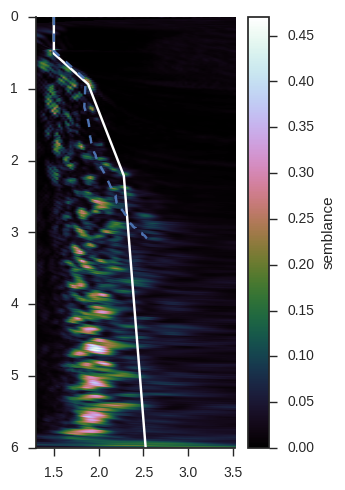

In [57]:
t = np.arange(n1)*d1 + o1
x = np.arange(n2)*d2 + o2
extent=[x[0], x[-1], t[-1], t[0]]

x, t = np.meshgrid(x,t)

plt.figure(figsize=(3.5,5))
img = plt.imshow(data.T, aspect='auto', cmap='cubehelix', extent=extent)
#plt.contour(x, t, data.T, 3, colors='k', linewidths=1)
plt.plot(picks.VSTK, picks.TWT, color='white')
plt.plot(rms.VRMS/1000., rms.TWT, ls='--')
sns.despine()
plt.axis('tight')
plt.colorbar(img, label='semblance')

plt.tight_layout()

In [47]:
from scipy.interpolate import interp1d

In [58]:
ncdp = 2142

vstk = interp1d(picks.TWT, picks.VSTK)
t = np.arange(n1)*d1 + o1
vstk = vstk(t)
vstk = np.tile(vstk, ncdp).reshape(ncdp, -1)

out = sf.Output('first_stacking_velocity.rsf')
out.put('n1', n1)
out.put('n2', ncdp)
out.put('d1', d1)
out.put('o1', o1)

out.write(vstk)
out.close()

vstk = 'first_stacking_velocity.rsf'

In [59]:
brute_stack = 'brute_stack.rsf'

!sfpow tpow=2 < {raw_cdp} | \
    sfnmo velocity={vstk} offset={offsets} mask={mask} half=n | \
    sfstack  | sfagc > {brute_stack}

sfnmo: CMP 2142 of 2142;MP 736 of 2142;CMP 959 of 2142;CMP 1038 of 2142;CMP 1367 of 2142;


In [60]:
img = sf.Input(brute_stack)

n1 = img.int('n1')
n2 = img.int('n2')
d1 = img.float('d1')
o1 = img.float('o1')
d2 = img.float('d2')
o2 = img.float('o2')

data = np.zeros((n2, n1), dtype=np.float32)
img.read(data)

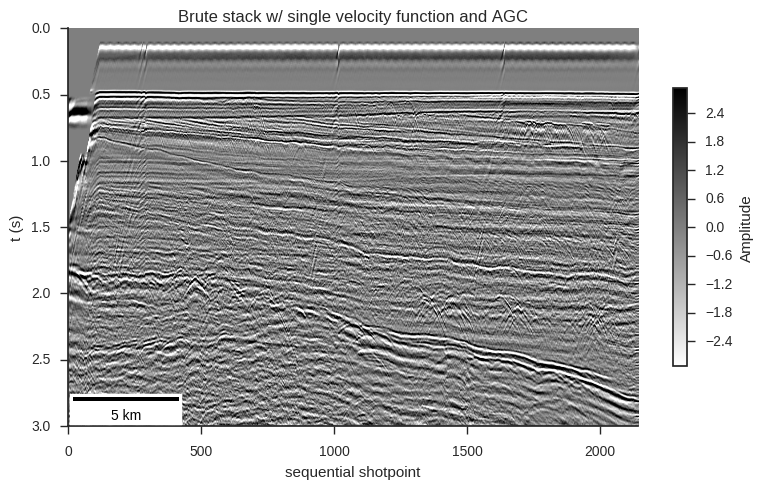

In [61]:
perc = np.percentile(data.ravel(), 99)
t = np.arange(n1) * d1 + o1
extent = [0, n2, t[-1], o1]
plt.figure(figsize=(8, 5))
img = plt.imshow(data.clip(-perc, perc).T, aspect='auto',
                 extent=extent, cmap='gray_r')


scalebar = ScaleBar(12.5, location='lower left') # 1 pixel = 25 meter
plt.gca().add_artist(scalebar)

plt.ylabel('t (s)')
plt.xlabel('sequential shotpoint')

plt.ylim(3,0)

plt.title('Brute stack w/ single velocity function and AGC')

sns.despine()
plt.colorbar(img, shrink=0.7, label='Amplitude')

plt.tight_layout()

# Constant velocity stack panels

The final step is to make sure if there are any important events being missed on our brute stack. One way to make that is to create multiple CVS panels and see if any important event pops up, specially below three seconds.

In [33]:
nv=100
dv=0.05
v0=1.5


stack = 'raw_csv_stacks.rsf'

# !sfpow pow1=2 < {raw_cdp} | \
#     sfstacks half=n offset={offsets} nv={nv} v0={v0} dv={dv} mask={mask} | \
#     sftransp plane=23 memsize=1300 | \
#     sfput label2=cdp | \
#     sfbyte gainpanel=e > {stack}

I checked the stacks above, there's no sign of any coherent signal below ~3 s.